# 196 Preliminary Work

In this notebook, we demonstrate and implement a prequential pipeline consisting of an Adaptive Random Forest (ARF) online classifier, ADWIN2 concept drift detector, and both OFS and FIRES online feature extraction and selection for comparison.

At this point, all modules used are in their default parameters.

Note: Install dependencies first via pip install -r requirements.txt

### Imports

In [2]:
# Main Imports
from skmultiflow.meta import AdaptiveRandomForestClassifier # ARF
from skmultiflow.lazy import KNNClassifier, KNNADWINClassifier # KNN
from sklearn.svm import LinearSVC # SVM

from skmultiflow.evaluation import EvaluatePrequential # Pipeline
from float.pipeline import PrequentialPipeline
from float.prediction.skmultiflow import SkmultiflowClassifier
from float.prediction.evaluation import PredictionEvaluator

from skmultiflow.drift_detection import ADWIN # ADWIN drift detection
from float.feature_selection import OFS, FIRES # online feature methods
# from skmultiflow.data import FileStream # create stream from file
from float.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from float.feature_selection.evaluation import FeatureSelectionEvaluator
from float.feature_selection.evaluation.measures import nogueira_stability

# Other imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Data Stream

In [7]:
# Create a data stream from file
# if from dataframe, use DataStream() instead
# stream = FileStream('out.csv') # dummy dataset
data_loader = DataLoader(path='out.csv', target_col=-1)

### Online Feature Extraction and Selection

In [8]:
ref_sample, _ = data_loader.get_data(50)
data_loader.stream.reset()

fires_fs = FIRES(n_total_features=data_loader.stream.n_features,
                n_selected_features=10,
                classes=data_loader.stream.target_values,
                baseline='gaussian',
                ref_sample=ref_sample)

ofs_fs = OFS(n_total_features=data_loader.stream.n_features,
            n_selected_features=10,
            baseline='gaussian',
            ref_sample=ref_sample)

### ARF + ADWIN Model

In [7]:
# Setup Adaptive Random Forest Classifier
arf = AdaptiveRandomForestClassifier()

# Setup variables to control loop and track performance
n_samples = 0
correct_cnt = 0
max_samples = data_loader.stream.n_remaining_samples()

# Lists to store true and predicted labels for metric calculations
true_labels = []
pred_labels = []

# Train the estimator with the samples provided by the data stream
while n_samples < max_samples and data_loader.stream.has_more_samples():
    X, y = data_loader.stream.next_sample()
    
    # Apply OFS feature selection
    X_selected = ofs_fs.select_features(X, rng=np.random.default_rng())
    
    y_pred = arf.predict(X_selected)
    true_labels.append(y[0])
    pred_labels.append(y_pred[0])
    if y[0] == y_pred[0]:
        correct_cnt += 1
    arf.partial_fit(X_selected, y)
    n_samples += 1

# Calculate metrics
accuracy = correct_cnt / n_samples
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')

# Display results
print('Adaptive Random Forest ensemble classifier example')
print('{} samples analyzed.'.format(n_samples))
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1))

Adaptive Random Forest ensemble classifier example
225710 samples analyzed.
Accuracy: 0.9976917283239555
Precision: 0.9976199129484853
Recall: 0.9976789717699962
F1 Score: 0.9976493927262007


In [22]:
import skmultiflow
print(skmultiflow.__version__)


0.5.3


In [39]:
pip install scikit-multiflow matplotlib sklearn


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

### Evaluation Pipeline (Prequential)

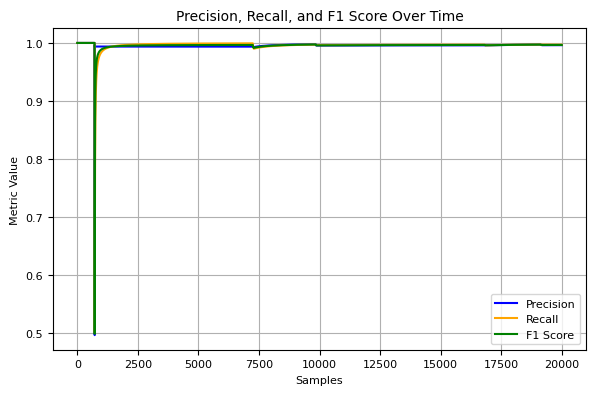

In [51]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Setup Adaptive Random Forest Classifier
arf = AdaptiveRandomForestClassifier()

# Initialize performance metrics tracking lists
n_samples = 0
true_labels = []
pred_labels = []
precision_list = []
recall_list = []
f1_list = []

# Prequential loop - train and test one sample at a time
while data_loader.stream.has_more_samples() and n_samples < 20000:
    # Fetch the next sample
    X, y = data_loader.stream.next_sample()
    
    # Apply OFS feature selection
    X_selected = ofs_fs.select_features(X, rng=np.random.default_rng())
    
    # Predict before training with the current sample
    y_pred = arf.predict(X_selected)
    
    # Update true and predicted labels for metrics
    true_labels.append(y[0])
    pred_labels.append(y_pred[0])

    # Incrementally train the model with the current sample
    # Ensure 'y' is passed as a list, NOT numpy arrays
    arf.partial_fit(X_selected, [y[0]], classes=data_loader.stream.target_values)

    # Calculate precision, recall, and f1 at this point in time
    precision = precision_score(true_labels, pred_labels, average='macro', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='macro', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='macro', zero_division=0)
    
    # Record the metrics at each step
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    
    # Increment sample counter
    n_samples += 1

# Combined plotting of Precision, Recall, and F1 Score
plt.figure(figsize=(6, 4))

plt.plot(precision_list, label='Precision', color='blue', linewidth=1.5)
plt.plot(recall_list, label='Recall', color='orange', linewidth=1.5)
plt.plot(f1_list, label='F1 Score', color='green', linewidth=1.5)

plt.xlabel('Samples')
plt.ylabel('Metric Value')
plt.title('Precision, Recall, and F1 Score Over Time')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


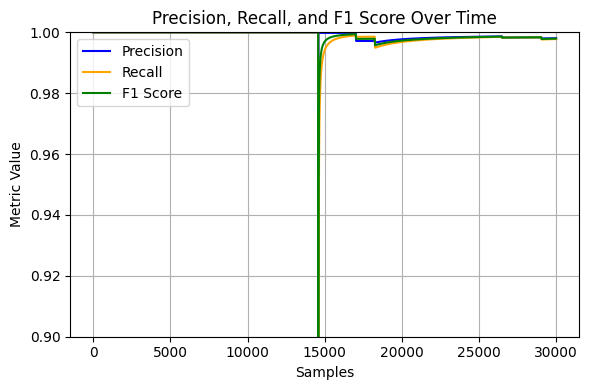

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Setup Adaptive Random Forest Classifier
arf = AdaptiveRandomForestClassifier()

# Initialize performance metrics tracking lists
n_samples = 0
true_labels = []
pred_labels = []
precision_list = []
recall_list = []
f1_list = []

# Prequential loop - train and test one sample at a time
while data_loader.stream.has_more_samples() and n_samples < 30000:
    # Fetch the next sample
    X, y = data_loader.stream.next_sample()
    
    # Apply OFS feature selection
    X_selected = ofs_fs.select_features(X, rng=np.random.default_rng())
    
    # Predict before training with the current sample
    y_pred = arf.predict(X_selected)
    
    # Update true and predicted labels for metrics
    true_labels.append(y[0])
    pred_labels.append(y_pred[0])

    # Incrementally train the model with the current sample
    # Ensure 'y' is passed as a list, NOT numpy arrays
    arf.partial_fit(X_selected, [y[0]], classes=data_loader.stream.target_values)

    # Calculate precision, recall, and f1 at this point in time
    precision = precision_score(true_labels, pred_labels, average='macro', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='macro', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='macro', zero_division=0)
    
    # Record the metrics at each step
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    
    # Increment sample counter
    n_samples += 1

# Combined plotting of Precision, Recall, and F1 Score
plt.figure(figsize=(6, 4))

plt.plot(precision_list, label='Precision', color='blue', linewidth=1.5)
plt.plot(recall_list, label='Recall', color='orange', linewidth=1.5)
plt.plot(f1_list, label='F1 Score', color='green', linewidth=1.5)

plt.xlabel('Samples')
plt.ylabel('Metric Value')
plt.title('Precision, Recall, and F1 Score Over Time')
plt.legend()
plt.grid()
plt.ylim(0.9, 1.0)  # Set y-axis range from 0.9 to 1.0
plt.tight_layout()
plt.show()


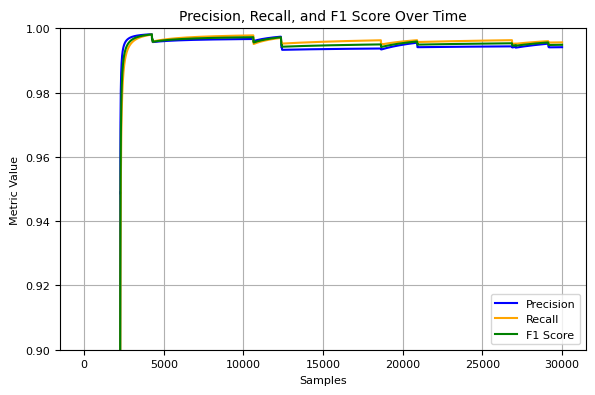

In [55]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Setup Adaptive Random Forest Classifier
arf = AdaptiveRandomForestClassifier()

# Initialize performance metrics tracking lists
n_samples = 0
true_labels = []
pred_labels = []
precision_list = []
recall_list = []
f1_list = []

# Prequential loop - train and test one sample at a time
while data_loader.stream.has_more_samples() and n_samples < 30000:
    # Fetch the next sample
    X, y = data_loader.stream.next_sample()
    
    # Apply OFS feature selection
    X_selected = ofs_fs.select_features(X, rng=np.random.default_rng())
    
    # Predict before training with the current sample
    y_pred = arf.predict(X_selected)
    
    # Update true and predicted labels for metrics
    true_labels.append(y[0])
    pred_labels.append(y_pred[0])

    # Incrementally train the model with the current sample
    # Ensure 'y' is passed as a list, NOT numpy arrays
    arf.partial_fit(X_selected, [y[0]], classes=data_loader.stream.target_values)

    # Calculate precision, recall, and f1 at this point in time
    precision = precision_score(true_labels, pred_labels, average='macro', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='macro', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='macro', zero_division=0)
    
    # Record the metrics at each step
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    
    # Increment sample counter
    n_samples += 1

# Combined plotting of Precision, Recall, and F1 Score
plt.figure(figsize=(6, 4))

plt.plot(precision_list, label='Precision', color='blue', linewidth=1.5)
plt.plot(recall_list, label='Recall', color='orange', linewidth=1.5)
plt.plot(f1_list, label='F1 Score', color='green', linewidth=1.5)

plt.xlabel('Samples')
plt.ylabel('Metric Value')
plt.title('Precision, Recall, and F1 Score Over Time')
plt.legend()
plt.grid()
plt.ylim(0.9, 1.0)  # Set y-axis range from 0.9 to 1.0
plt.tight_layout()
plt.show()

In [9]:
# Initialize accuracy tracking list
accuracy_list = []

# Reset the data stream
data_loader.stream.reset()

# Setup Adaptive Random Forest Classifier
arf = AdaptiveRandomForestClassifier()

# Initialize performance metrics tracking lists
n_samples = 0
true_labels = []
pred_labels = []
precision_list = []
recall_list = []
f1_list = []
accuracy_list = []

# Prequential loop - train and test one sample at a time
while data_loader.stream.has_more_samples() and n_samples < 30000:
    # Fetch the next sample
    X, y = data_loader.stream.next_sample()
    
    # Apply OFS feature selection
    X_selected = ofs_fs.select_features(X, rng=np.random.default_rng())
    
    # Predict before training with the current sample
    y_pred = arf.predict(X_selected)
    
    # Update true and predicted labels for metrics
    true_labels.append(y[0])
    pred_labels.append(y_pred[0])

    # Incrementally train the model with the current sample
    # Ensure 'y' is passed as a list, NOT numpy arrays
    arf.partial_fit(X_selected, [y[0]], classes=data_loader.stream.target_values)

    # Calculate precision, recall, f1, and accuracy at this point in time
    precision = precision_score(true_labels, pred_labels, average='macro', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='macro', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='macro', zero_division=0)
    accuracy = accuracy_score(true_labels, pred_labels)
    
    # Record the metrics at each step
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    accuracy_list.append(accuracy)
    
    # Increment sample counter
    n_samples += 1

# Combined plotting of Precision, Recall, F1 Score, and Accuracy
plt.figure(figsize=(6, 4))

plt.plot(precision_list, label='Precision', color='blue', linewidth=1.5)
plt.plot(recall_list, label='Recall', color='orange', linewidth=1.5)
plt.plot(f1_list, label='F1 Score', color='green', linewidth=1.5)
plt.plot(accuracy_list, label='Accuracy', color='red', linewidth=1.5)

plt.xlabel('Samples')
plt.ylabel('Metric Value')
plt.title('Precision, Recall, F1 Score, and Accuracy Over Time')
plt.legend()
plt.grid()
plt.ylim(0.9, 1.0)  # Set y-axis range from 0.9 to 1.0
plt.tight_layout()
plt.show()

KeyboardInterrupt: 